In [1]:
# system / paths
import os
import sys
from pathlib import Path

# numerical / data
import numpy as np
import pandas as pd
import random

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# audio processing
import librosa
import soundfile as sf
# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# filtering and audio playback
from scipy.signal import butter, filtfilt
from IPython.display import Audio, display

# project paths
project_root = Path(os.getcwd()).parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# CWD is assumed to be notebooks/icbhi CWD = Path().resolve() # heart_and_lungsounds/ PROJECT_ROOT = CWD.parents[1]
CWD = Path().resolve()  # heart_and_lungsounds/
PROJECT_ROOT = CWD.parents[1]

RAW_ROOT = PROJECT_ROOT / "data" / "raw" / "icbhi"
AUDIO_DIR = RAW_ROOT / "audio_and_txt_files"
PATIENT_CSV = RAW_ROOT / "patient_diagnosis.csv"
DEMOGRAPHIC_TXT = RAW_ROOT / "demographic_info.txt"
PROC_ROOT = PROJECT_ROOT / "data" / "processed" / "icbhi"
META_CSV = PROC_ROOT / "icbhi_metadata.csv"
ANNOT_CSV = PROC_ROOT / "icbhi_annotation_data.csv"

print("cwd         :", CWD)
print("project_root:", PROJECT_ROOT)
print("raw_root    :", RAW_ROOT)
print("audio_dir   :", AUDIO_DIR)
print("patient_csv :", PATIENT_CSV)
print("meta_csv  :", META_CSV)
print("annot_csv :", ANNOT_CSV)
print("audio_dir :", AUDIO_DIR)

cwd         : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\notebooks\icbhi
project_root: C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds
raw_root    : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\raw\icbhi
audio_dir   : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\raw\icbhi\audio_and_txt_files
patient_csv : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\raw\icbhi\patient_diagnosis.csv
meta_csv  : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\icbhi\icbhi_metadata.csv
annot_csv : C:\Users\Esmee Werk\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_que

In [2]:
# Load annotation data
annotations_df = pd.read_csv(ANNOT_CSV)

print("annotations_df shape:", annotations_df.shape)
annotations_df.head()

annotations_df shape: (6898, 9)


,start_sec,end_sec,duration_sec,crackle_flag,wheeze_flag,label,record_id,patient_id,diagnosis
0,0.036,0.579,0.543,0,0,normal,101_1b1_Al_sc_Meditron,101,URTI
1,0.579,2.450,1.871,0,0,normal,101_1b1_Al_sc_Meditron,101,URTI
2,2.450,3.893,1.443,0,0,normal,101_1b1_Al_sc_Meditron,101,URTI
3,3.893,5.793,1.900,0,0,normal,101_1b1_Al_sc_Meditron,101,URTI
4,5.793,7.521,1.728,0,0,normal,101_1b1_Al_sc_Meditron,101,URTI


In [3]:
annotations_df['label'].value_counts()

label
normal            3642
crackle           1864
wheeze             886
crackle+wheeze     506
Name: count, dtype: int64

In [4]:
metadata_df = pd.read_csv(META_CSV)

print("metadata_df shape:", metadata_df.shape)
metadata_df.head()

metadata_df shape: (920, 10)


,file_name,samplerate,frames,duration_sec,channels,patient_id,chest_location,mode,equipment,diagnosis
0,101_1b1_Al_sc_Meditron.wav,44100,882000,20.00,1,101,Al,sc,Meditron,URTI
1,101_1b1_Pr_sc_Meditron.wav,44100,882000,20.00,1,101,Pr,sc,Meditron,URTI
2,102_1b1_Ar_sc_Meditron.wav,44100,882000,20.00,1,102,Ar,sc,Meditron,Healthy
3,103_2b2_Ar_mc_LittC2SE.wav,44100,882000,20.00,1,103,Ar,mc,LittC2SE,Asthma
4,104_1b1_Al_sc_Litt3200.wav,4000,63424,15.86,1,104,Al,sc,Litt3200,COPD


In [ ]:
TARGET_SR = 4000  # Hz

def load_icbhi_audio_from_filename(file_name: str, audio_dir: Path, sr: int = TARGET_SR):
    """
    Laad één ICBHI .wav bestand op basis van file_name.
    Downsamplet direct naar sr Hz (mono).
    """
    wav_path = audio_dir / file_name
    if not wav_path.exists():
        raise FileNotFoundError(f"Audio file not found: {wav_path}")

    # librosa load → mono, resample naar sr
    y, sr_loaded = librosa.load(str(wav_path), sr=sr, mono=True)
    return y, sr_loaded, wav_path

# Audio laden voor elke rij in metadata_df
def attach_audio_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    audios = []
    srs = []
    paths = []

    for fn in df["file_name"]:
        y, sr_loaded, wav_path = load_icbhi_audio_from_filename(fn, AUDIO_DIR, sr=TARGET_SR)
        audios.append(y)
        srs.append(sr_loaded)
        paths.append(str(wav_path))

    df["audio"] = audios
    df["sr"] = srs
    df["audio_path"] = paths

    return df

metadata_df = attach_audio_columns(metadata_df)
metadata_df.head()

,file_name,samplerate,frames,duration_sec,channels,patient_id,chest_location,mode,equipment,diagnosis,audio,sr,audio_path
0,101_1b1_Al_sc_Meditron.wav,44100,882000,20.00,1,101,Al,sc,Meditron,URTI,"[0.05205711, 0.10541952, 0.09506713, 0.1032429...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...
1,101_1b1_Pr_sc_Meditron.wav,44100,882000,20.00,1,101,Pr,sc,Meditron,URTI,"[-0.020205673, -0.04060134, -0.03620533, -0.04...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...
2,102_1b1_Ar_sc_Meditron.wav,44100,882000,20.00,1,102,Ar,sc,Meditron,Healthy,"[0.002122723, 0.0040537072, 0.003369953, 0.003...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...
3,103_2b2_Ar_mc_LittC2SE.wav,44100,882000,20.00,1,103,Ar,mc,LittC2SE,Asthma,"[-0.1874072, -0.36198732, -0.3035866, -0.31736...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...
4,104_1b1_Al_sc_Litt3200.wav,4000,63424,15.86,1,104,Al,sc,Litt3200,COPD,"[3.0517578e-05, -0.0002746582, -6.1035156e-05,...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...


In [ ]:
def butter_bandpass_filter(x: np.ndarray,fs: float,lowcut: float = 120.0,highcut: float = 1800.0,order: int = 1) -> np.ndarray:
    """
    12e-orde Butterworth band-pass filter (zero-phase via filtfilt).
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq

    if low <= 0 or high >= 1:
        raise ValueError(f"Invalid bandpass range: low={lowcut}, high={highcut}, fs={fs}")

    b, a = butter(order, [low, high], btype="bandpass")
    y = filtfilt(b, a, x)
    return y

def apply_icbhi_bandpass(df: pd.DataFrame) -> pd.DataFrame:
    """
    Maakt een nieuwe kolom 'filtered_audio' met
    12e-orde Butterworth band-pass (120–1800 Hz @ 4 kHz).
    """
    df = df.copy()
    df["filtered_audio"] = df.apply(
        lambda row: butter_bandpass_filter(row["audio"], row["sr"],
                                           lowcut=120.0, highcut=1800.0, order=12),
        axis=1,
    )
    return df

metadata_df = apply_icbhi_bandpass(metadata_df)
metadata_df.head()

,file_name,samplerate,frames,duration_sec,channels,patient_id,chest_location,mode,equipment,diagnosis,audio,sr,audio_path,filtered_audio
0,101_1b1_Al_sc_Meditron.wav,44100,882000,20.00,1,101,Al,sc,Meditron,URTI,"[0.05205711, 0.10541952, 0.09506713, 0.1032429...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[-0.0002736720263594025, 0.04658270767460648, ..."
1,101_1b1_Pr_sc_Meditron.wav,44100,882000,20.00,1,101,Pr,sc,Meditron,URTI,"[-0.020205673, -0.04060134, -0.03620533, -0.04...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[9.909576276697415e-05, -0.0172203918722869, -..."
2,102_1b1_Ar_sc_Meditron.wav,44100,882000,20.00,1,102,Ar,sc,Meditron,Healthy,"[0.002122723, 0.0040537072, 0.003369953, 0.003...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[-0.000153770427900877, 0.0014088673681735666,..."
3,103_2b2_Ar_mc_LittC2SE.wav,44100,882000,20.00,1,103,Ar,mc,LittC2SE,Asthma,"[-0.1874072, -0.36198732, -0.3035866, -0.31736...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[0.0006824938113982899, -0.16617764794337722, ..."
4,104_1b1_Al_sc_Litt3200.wav,4000,63424,15.86,1,104,Al,sc,Litt3200,COPD,"[3.0517578e-05, -0.0002746582, -6.1035156e-05,...",4000,C:\Users\Esmee Werk\Documents\Persoonlijke Pro...,"[6.0773857526561284e-05, -0.000163676759877836..."


In [ ]:
from IPython.display import Audio, display

CHEST_LOCATION_MAP_ICBHI = {
    "Al": "anterior left",
    "Ar": "anterior right",
    "Pl": "posterior left",
    "Pr": "posterior right",
    "Ll": "lateral left",
    "Lr": "lateral right",
}

def plot_raw_vs_filtered(row, time_window=None, fixed_ylim=(-0.5, 0.5)):
    """
    Plot raw vs filtered ICBHI recording in black & white with:
      - fixed y-axis (default [-0.5, 0.5])
      - x-ticks every 0.5 s
      - y-ticks every 0.1
      - clear white grid

    Title format:
      <file_name> – <diagnosis> – <full chest location>
    """
    y_raw_full = row["audio"]
    y_filt_full = row["filtered_audio"]
    sr = row["sr"]

    # Optional time window
    if time_window is not None:
        t_start, t_end = time_window
        n_start = int(t_start * sr)
        n_end = int(t_end * sr)
        y_raw = y_raw_full[n_start:n_end]
        y_filt = y_filt_full[n_start:n_end]
        t = np.arange(len(y_raw)) / sr + t_start
    else:
        y_raw = y_raw_full
        y_filt = y_filt_full
        t = np.arange(len(y_raw)) / sr

    # X axis
    x_min = float(t[0])
    x_max = float(t[-1])
    x_start_tick = 0.0 if x_min <= 0.0 + 1e-9 else x_min
    x_ticks = np.arange(x_start_tick, x_max + 0.5, 0.5)

    # Y axis
    y_min, y_max = fixed_ylim
    y_ticks = np.arange(y_min, y_max + 1e-9, 0.1)

    # Title parts: file_name, diagnosis, expanded chest_location
    file_name = row.get("file_name", "unknown.wav")

    diag = str(row.get("diagnosis", "")).strip()
    diag_part = diag if diag else ""

    loc_code = str(row.get("chest_location", "")).strip()
    loc_full = CHEST_LOCATION_MAP_ICBHI.get(loc_code, loc_code) if loc_code else ""

    title_parts = [file_name]
    if diag_part:
        title_parts.append(diag_part)
    if loc_full:
        title_parts.append(loc_full)

    suptitle = " – ".join(title_parts)

    # Figure
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True, sharey=True)
    fig.suptitle(suptitle, fontsize=12)

    def style_axis(ax, title):
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(x_ticks)
        ax.set_yticks(y_ticks)
        ax.grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.9)
        ax.set_ylabel("Amplitude")
        ax.set_title(title, fontsize=11)

    # Top: raw
    axes[0].plot(t, y_raw, color="black", linewidth=0.7)
    style_axis(axes[0], "Raw signal")

    # Bottom: filtered
    axes[1].plot(t, y_filt, color="black", linewidth=0.7)
    style_axis(axes[1], "Filtered signal (12th-order Butterworth, 120–1800 Hz)")
    axes[1].set_xlabel("Time (s)")

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

    print("Playback – raw (full recording):")
    display(Audio(y_raw_full, rate=sr))

    print("Playback – filtered (full recording):")
    display(Audio(y_filt_full, rate=sr))

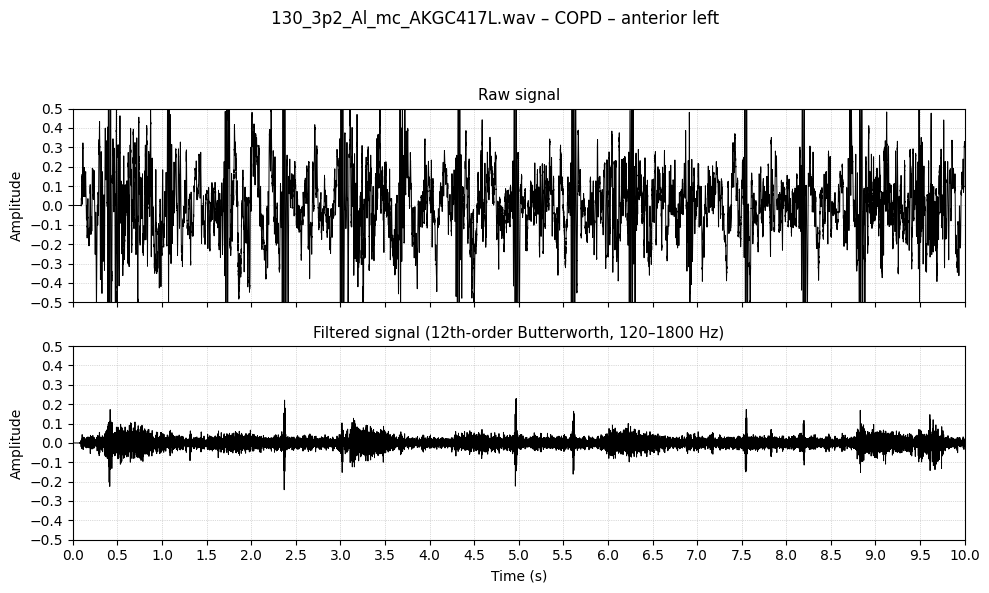

Playback – raw (full recording):


Playback – filtered (full recording):


In [8]:
example_row = metadata_df.query("file_name == '130_3p2_Al_mc_AKGC417L.wav'").iloc[0]

# Zelfde stijl als jouw voorbeeld: 0–10 s, vaste y-as
plot_raw_vs_filtered(
    example_row,
    time_window=(0.0, 10.0),
    fixed_ylim=(-0.5, 0.5)   # pas aan als je een andere schaal wilt
)

In [ ]:
# record_id = bestandsnaam zonder .wav, zodat het matcht met annotations_df
metadata_df = metadata_df.copy()
metadata_df["record_id"] = metadata_df["file_name"].apply(lambda fn: Path(fn).stem)

# sanity check
print(
    "metadata_df recordings:", metadata_df["record_id"].nunique(),
    "annotations_df recordings:", annotations_df["record_id"].nunique()
)

metadata_df recordings: 920 annotations_df recordings: 920


In [ ]:
from collections import defaultdict

def compute_label_overlap_for_segment(annots_rec, seg_start, seg_end):
    """
    Berekent per label hoeveel seconde overlap er is met het segment [seg_start, seg_end].

    Parameters
    ----------
    annots_rec : pd.DataFrame
        Subset van annotations_df voor één record_id.
        Verwacht kolommen: start_sec, end_sec, label.
    seg_start, seg_end : float
        Segment in seconden.

    Returns
    -------
    overlaps : dict
        {label: overlap_in_seconds}
    """
    overlaps = defaultdict(float)
    for _, row in annots_rec.iterrows():
        a_start = row["start_sec"]
        a_end = row["end_sec"]
        lab = row["label"]

        # overlap tussen [a_start, a_end] en [seg_start, seg_end]
        overlap = max(0.0, min(seg_end, a_end) - max(seg_start, a_start))
        if overlap > 0:
            overlaps[lab] += overlap
    return overlaps

In [11]:
def decide_acoustic_label(overlaps, seg_duration, dominance_thresh=0.7):
    """
    Bepaalt het akoestische label van een segment op basis van tijds-overlap.

    Logica:
    - Als 'crackle+wheeze' enige overlap heeft → 'mixed' (segment blijft)
    - Anders: als één van ['normal', 'wheeze', 'crackle'] >= dominance_thresh → die klasse
    - Anders: 'reject' (segment weggooien)
    """
    if seg_duration <= 0:
        return "reject"

    # Fracties per label binnen het segment
    frac = {lab: t / seg_duration for lab, t in overlaps.items()}

    # 1) crackle+wheeze aanwezig → mixed
    if frac.get("crackle+wheeze", 0.0) > 0:
        return "mixed"

    # 2) dominante enkelvoudige klasse zoeken
    candidates = ["normal", "wheeze", "crackle"]
    dominant_label = None
    dominant_frac = 0.0

    for lab in candidates:
        f = frac.get(lab, 0.0)
        if f > dominant_frac:
            dominant_frac = f
            dominant_label = lab

    if dominant_label is not None and dominant_frac >= dominance_thresh:
        return dominant_label

    # 3) geen duidelijke meerderheid → reject
    return "reject"

In [ ]:
def segment_record(
    meta_row,
    annots_rec,
    audio_col="filtered_audio",
    window_sec=2.5,
    hop_sec=1.0,
    dominance_thresh=0.7,
    keep_mixed=True,
):
    """
    Maakt vaste segmenten voor één recording (record_id).

    Parameters
    ----------
    meta_row : pd.Series
        Eén rij uit metadata_df met o.a. 'record_id', 'audio'/'filtered_audio', 'sr',
        'patient_id', 'diagnosis', 'chest_location', 'file_name'.
    annots_rec : pd.DataFrame
        Annotaties voor deze recording (subset van annotations_df op record_id).
    audio_col : str
        Kolomnaam in meta_row die gebruikt wordt als bronaudio (bijv. 'filtered_audio' of 'audio').
    window_sec : float
        Segmentduur in seconden (standaard 2.5).
    hop_sec : float
        Hop size tussen segmenten in seconden (standaard 1.0).
    dominance_thresh : float
        Minimaal deel van segmentduur voor een dominante klasse.
    keep_mixed : bool
        True: mixed segmenten behouden; False: mixed segmenten droppen.

    Returns
    -------
    segments : list of dict
        Eén dict per segment met metadata, label en audiosnede.
    """
    y = meta_row[audio_col]
    sr = meta_row["sr"]

    total_samples = len(y)
    total_duration = total_samples / sr

    win_samp = int(round(window_sec * sr))
    hop_samp = int(round(hop_sec * sr))

    if total_samples < win_samp:
        return []  # opname te kort voor één segment

    segments = []
    seg_idx = 0
    start_sample = 0

    while start_sample + win_samp <= total_samples:
        end_sample = start_sample + win_samp

        seg_start_sec = start_sample / sr
        seg_end_sec = end_sample / sr
        seg_duration = seg_end_sec - seg_start_sec  # zou ~window_sec moeten zijn

        # overlap met annotaties
        overlaps = compute_label_overlap_for_segment(
            annots_rec, seg_start_sec, seg_end_sec
        )
        acoustic_label = decide_acoustic_label(
            overlaps, seg_duration, dominance_thresh=dominance_thresh
        )

        if not keep_mixed and acoustic_label == "mixed":
            # skippen
            start_sample += hop_samp
            seg_idx += 1
            continue

        # audiosnede (numpy array)
        seg_audio = y[start_sample:end_sample]

        # fractions opslaan voor inspectie/debug
        frac_normal = overlaps.get("normal", 0.0) / seg_duration if seg_duration > 0 else 0.0
        frac_wheeze = overlaps.get("wheeze", 0.0) / seg_duration if seg_duration > 0 else 0.0
        frac_crackle = overlaps.get("crackle", 0.0) / seg_duration if seg_duration > 0 else 0.0
        frac_mix = overlaps.get("crackle+wheeze", 0.0) / seg_duration if seg_duration > 0 else 0.0

        segments.append(
            {
                "record_id": meta_row["record_id"],
                "file_name": meta_row["file_name"],
                "segment_index": seg_idx,
                "seg_start_sec": seg_start_sec,
                "seg_end_sec": seg_end_sec,
                "seg_duration_sec": seg_duration,
                "acoustic_label": acoustic_label,
                "frac_normal": frac_normal,
                "frac_wheeze": frac_wheeze,
                "frac_crackle": frac_crackle,
                "frac_crackle_wheeze": frac_mix,
                # klinische info
                "patient_id": meta_row.get("patient_id", np.nan),
                "diagnosis": meta_row.get("diagnosis", None),
                "chest_location": meta_row.get("chest_location", None),
                # audio segment zelf (voor CNN)
                "audio_segment": seg_audio,
                "sr": sr,
            }
        )

        start_sample += hop_samp
        seg_idx += 1

    return segments


In [ ]:
def make_icbhi_segments(
    metadata_df,
    annotations_df,
    audio_col="filtered_audio",
    window_sec=2.5,
    hop_sec=1.0,
    dominance_thresh=0.7,
    keep_mixed=True,
):
    """
    Maakt een segment-level DataFrame op basis van metadata_df en annotations_df.
    """
    segments_all = []

    # zorg dat annotaties per record gesorteerd zijn
    annotations_df = annotations_df.sort_values(["record_id", "start_sec"])

    for _, meta_row in metadata_df.iterrows():
        rid = meta_row["record_id"]
        annots_rec = annotations_df[annotations_df["record_id"] == rid]

        if annots_rec.empty:
            # Geen annotaties beschikbaar → eventueel skippen
            continue

        segs = segment_record(
            meta_row,
            annots_rec,
            audio_col=audio_col,
            window_sec=window_sec,
            hop_sec=hop_sec,
            dominance_thresh=dominance_thresh,
            keep_mixed=keep_mixed,
        )
        segments_all.extend(segs)

    segments_df = pd.DataFrame(segments_all)
    return segments_df

# Aanroep: gebruik gefilterde audio (logisch voor CNN)
segments_df = make_icbhi_segments(
    metadata_df,
    annotations_df,
    audio_col="filtered_audio",  # of "audio" als je raw wilt
    window_sec=2.5,
    hop_sec=1.0,
    dominance_thresh=0.85,
    keep_mixed=True,             # zet False als je mixed wilt weggooien
)

print("segments_df shape:", segments_df.shape)
segments_df.head()


In [ ]:
segments_df["acoustic_label"].value_counts()

acoustic_label
normal     7305
crackle    3782
reject     3353
mixed      1903
wheeze     1591
Name: count, dtype: int64

In [ ]:
segments_df.query("record_id == '205_1b3_Lr_mc_AKGC417L'")[[
    "segment_index", "seg_start_sec", "seg_end_sec",
    "acoustic_label", "frac_normal", "frac_wheeze", "frac_crackle", "frac_crackle_wheeze"
]]

,segment_index,seg_start_sec,seg_end_sec,acoustic_label,frac_normal,frac_wheeze,frac_crackle,frac_crackle_wheeze
15213,0,0.0,2.5,reject,0.5500,0.0,0.0000,0.0
15214,1,1.0,3.5,reject,0.8904,0.0,0.0596,0.0
15215,2,2.0,4.5,reject,0.5404,0.0,0.4596,0.0
15216,3,3.0,5.5,reject,0.1404,0.0,0.8596,0.0
15217,4,4.0,6.5,crackle,0.0000,0.0,1.0000,0.0
15218,5,5.0,7.5,crackle,0.0000,0.0,1.0000,0.0
15219,6,6.0,8.5,crackle,0.0000,0.0,1.0000,0.0
15220,7,7.0,9.5,crackle,0.0000,0.0,1.0000,0.0
15221,8,8.0,10.5,crackle,0.0000,0.0,1.0000,0.0
15222,9,9.0,11.5,reject,0.3832,0.0,0.6168,0.0


In [ ]:
from matplotlib.patches import Patch, Rectangle

def plot_icbhi_segmentation_for_record(
    record_id: str,
    metadata_df: pd.DataFrame,
    segments_df: pd.DataFrame,
    audio_col: str = "filtered_audio",
    window_sec: float = 2.5,
    hop_sec: float = 1.0,
):
    """
    Visualize segmentation for a single ICBHI recording.

    - Plots full waveform
    - Draws colored segment blocks (skips 'reject')
    - Thin border for segments
    - Label letters: N, C, W, M
    - X-axis padded and in 1s ticks
    - Y-axis automatic
    - Horizontal legend in the lower right
    """

    # --- Select recording ---
    meta_row = metadata_df.query("record_id == @record_id")
    if meta_row.empty:
        raise ValueError(f"record_id '{record_id}' not found in metadata_df")
    meta_row = meta_row.iloc[0]

    y = meta_row[audio_col]
    sr = meta_row["sr"]
    file_name = meta_row.get("file_name", f"{record_id}.wav")

    t = np.arange(len(y)) / sr

    # --- Select segments ---
    segs_rec = segments_df.query("record_id == @record_id").copy()
    if segs_rec.empty:
        raise ValueError(f"No segments found for record_id '{record_id}'")
    segs_rec = segs_rec.sort_values("seg_start_sec")

    # --- Colors ---
    color_map = {
        "normal":  "#5DA5DA",   # blue
        "crackle": "#F15854",   # red
        "wheeze":  "#FFBB78",   # yellow/orange
        "mixed":   "#B276B2",   # purple
        "reject":  "#AAAAAA",   # gray
    }

    short_label = {
        "normal":  "N",
        "crackle": "C",
        "wheeze":  "W",
        "mixed":   "M",
        "reject":  "R",
    }

    alpha = 0.35

    # --- Axis ranges ---
    raw_x_min = float(t[0])
    raw_x_max = float(t[-1])

    x_min = max(0.0, raw_x_min - 1.0)
    x_max = raw_x_max + 1.0
    x_ticks = np.arange(np.floor(x_min), np.ceil(x_max) + 1e-9, 1.0)

    # Y is now auto, but we need dynamic height for placing labels
    y_min_val = y.min()
    y_max_val = y.max()
    y_mid = y_max_val * 0.8 if y_max_val > 0 else y_max_val * 0.2

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(12, 3))

    # Waveform
    ax.plot(t, y, color="black", linewidth=0.6, alpha=0.9)

    # --- Segments (skip reject) ---
    for _, seg in segs_rec.iterrows():
        label = str(seg["acoustic_label"])
        if label == "reject":
            continue

        s = seg["seg_start_sec"]
        e = seg["seg_end_sec"]

        col = color_map[label]
        txt = short_label[label]

        # background
        ax.axvspan(s, e, color=col, alpha=alpha, zorder=0)

        # thin border
        rect = Rectangle(
            (s, y_min_val),
            e - s,
            y_max_val - y_min_val,
            linewidth=0.5,
            edgecolor=col,
            facecolor="none",
            alpha=0.9,
            zorder=1,
        )
        ax.add_patch(rect)

        # label
        x_center = (s + e) / 2
        ax.text(
            x_center,
            y_mid,
            txt,
            ha="center",
            va="center",
            fontsize=8,
            color="black",
            alpha=0.9,
        )

    # --- Axis styling ---
    ax.set_xlim(x_min, x_max)
    ax.set_xticks(x_ticks)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.grid(True, which="both", linestyle=":", linewidth=0.5, alpha=0.8)

    ax.set_title(f"Segmentation on {file_name} (window {window_sec}s, hop {hop_sec}s)", fontsize=11)

    # --- Legend (horizontal, lower right) ---
    legend_items = [
        ("normal",  "Normal"),
        ("crackle", "Crackle"),
        ("wheeze",  "Wheeze"),
        ("mixed",   "Crackle+Wheeze"),
    ]

    legend_patches = [
        Patch(facecolor=color_map[key], edgecolor=color_map[key], label=label)
        for key, label in legend_items
    ]

    ax.legend(
        handles=legend_patches,
        loc="lower right",
        ncol=4,
        frameon=True,
        fontsize=8,
        borderaxespad=0.5,
        handlelength=1.5,
        columnspacing=0.8,
    )

    plt.tight_layout()
    plt.show()

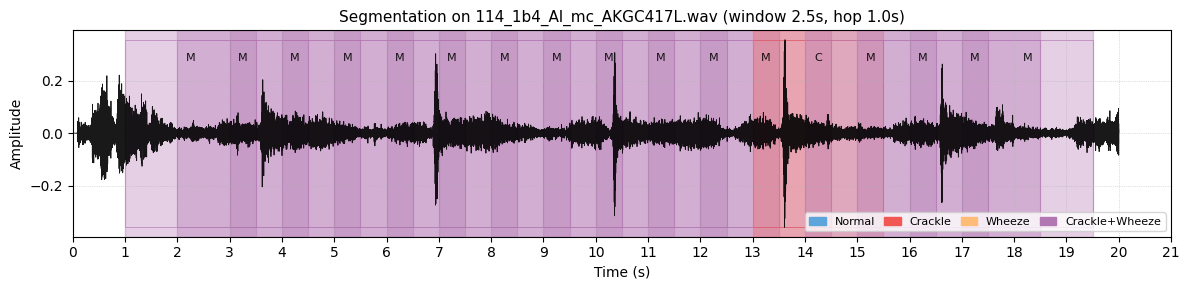

In [ ]:
# Neem een bestaand record_id uit segments_df
example_id = "114_1b4_Al_mc_AKGC417L"

plot_icbhi_segmentation_for_record(
    record_id=example_id,
    metadata_df=metadata_df,
    segments_df=segments_df,
    audio_col="filtered_audio",   # of "audio" voor raw
    window_sec=2.5,
    hop_sec=1.0,
)
